In [14]:
pip install pyts


Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the 'C:\Users\91707\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#importing libraries
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas import DataFrame
import pandas_datareader as web
import keras
import plotly.graph_objects as go
import tensorflow as tf
import pandas as pd
import itertools
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,LSTM
from __future__ import absolute_import,division,print_function
import os
import math

In [2]:
## reading the dataset
train_data=pd.read_csv('C:/Users/91707/OneDrive - LNMIIT/coding/data_Sci/Japan_cities_rainfall.csv')
#to_predict=pd.read_csv('/content/rainfall_to_predict.csv')

# making a copy of original datset 
train_data_original=train_data
#to_predict_original=to_predict

In [3]:
train_data.head()

,date_time,place,longitude,latitude,rainfall
0,20200918_080000,Naha,127.686667,26.206667,0.0
1,20200918_080000,Fukuoka,130.375000,33.581667,0.0
2,20200918_080000,Sendai,140.896667,38.261667,0.0
3,20200918_080000,Osaka,135.518333,34.681667,0.0
4,20200918_080000,Nigata,139.018333,37.893333,3.0


In [4]:
train_data.dtypes

date_time     object
place         object
longitude    float64
latitude     float64
rainfall     float64
dtype: object

In [5]:
## we shall make the date_time column to pandas datetime 
train_data['date_time'] = pd.to_datetime(train_data['date_time'],format='%Y%m%d_%H%M%S')

In [6]:
train_data.dtypes
## now date_time has changed to pandas datetime

date_time    datetime64[ns]
place                object
longitude           float64
latitude            float64
rainfall            float64
dtype: object

In [7]:
place_name = [' Tokyo',' Naha',' Sendai',' Osaka',' Nigata',' Fukuoka']

In [8]:

place_list= [
train_data.loc[train_data['place']==' Tokyo'],
train_data.loc[train_data['place']==' Naha'],
train_data.loc[train_data['place']==' Sendai'],
train_data.loc[train_data['place']==' Osaka'],
train_data.loc[train_data['place']==' Nigata'],
train_data.loc[train_data['place']==' Fukuoka']]

In [9]:
for i in place_list:
  i.index = i.date_time
  i.drop(['place','longitude','date_time','latitude'],axis = 1,inplace = True)
  

In [10]:
x=[]
for i in place_list:
  x.append(i.resample('30min').mean())
place_list = x.copy()

In [11]:
from pyts.preprocessing import InterpolationImputer
imputer = InterpolationImputer()
for i in range(0,6):
  new=place_list[i].rainfall
  new=imputer.transform([new])
  new = new[0].tolist()
  place_list[i]['rainfall'] = new
  #place_list[i].drop('r2',inplace=True,axis=1)

In [12]:
place_list[0][290:300]

,rainfall
date_time,
2020-09-24 09:00:00,1.0
2020-09-24 09:30:00,0.4
2020-09-24 10:00:00,0.0
2020-09-24 10:30:00,0.0
2020-09-24 11:00:00,0.0
2020-09-24 11:30:00,0.0
2020-09-24 12:00:00,0.0
2020-09-24 12:30:00,0.0
2020-09-24 13:00:00,0.0


#data preprocessing for LSTM

In [13]:
from sklearn.preprocessing import MinMaxScaler
place_dataset = []
scaler = MinMaxScaler(feature_range=(0, 1))
for i in place_list:
  dataset = i
  dataset = dataset.values
  dataset = dataset.astype('float32')
  dataset = scaler.fit_transform(dataset)
  place_dataset.append(dataset)

In [14]:
place_train_list=[]
place_test_list=[]
for i in place_dataset:
  dataset = i
  train_size = int(len(dataset) * 0.7)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  place_train_list.append(train)
  place_test_list.append(test)


array([[0.        ],
       [0.06666667],
       [0.06666667],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [15]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		#print(dataX)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [34]:
trainX_list = []
trainY_list=[]
testX_list =[]
testY_list=[]
for i in range(6):
  tX,tY = create_dataset(place_train_list[i])
  testx,testy = create_dataset(place_test_list[i])
  print(testx.shape)
  tX=np.reshape(tX, (tX.shape[0],  tX.shape[1],1))
  testx = np.reshape(testx, (testx.shape[0], testx.shape[1], 1))
  trainX_list.append(tX)
  trainY_list.append(tY)
  testX_list.append(testx)
  testY_list.append(testy)

(1007, 1)
(1007, 1)
(1007, 1)
(1007, 1)
(1007, 1)
(1007, 1)


In [25]:
#model_list=[]
for i in range(6):
  model = Sequential()
  model.add(LSTM(4 ,return_sequences = True,input_shape=(1, 1)))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')
  model_path = 'C:/Users/91707/OneDrive - LNMIIT/coding/data_Sci/rain_japan'+place_name[i] +'/weights.ckpt'
  #close_dir = os.path.dirname(model_path)
  #cp_callback = tf.keras.callbacks.ModelCheckpoint(model_path,save_weights_only=True,verbose= 1)
  model.fit(trainX_list[i], trainY_list[i], epochs=10, batch_size=1, verbose=2)
  #model_list.append(model)
  model.save(model_path)
  print(place_name[i])

Epoch 1/10
2352/2352 - 3s - loss: 0.0076
Epoch 2/10
2352/2352 - 3s - loss: 0.0021
Epoch 3/10
2352/2352 - 3s - loss: 0.0019
Epoch 4/10
2352/2352 - 4s - loss: 0.0018
Epoch 5/10
2352/2352 - 4s - loss: 0.0019
Epoch 6/10
2352/2352 - 4s - loss: 0.0018
Epoch 7/10
2352/2352 - 3s - loss: 0.0018
Epoch 8/10
2352/2352 - 3s - loss: 0.0018
Epoch 9/10
2352/2352 - 3s - loss: 0.0018
Epoch 10/10
2352/2352 - 4s - loss: 0.0018
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/91707/OneDrive - LNMIIT/coding/data_Sci/rain_japan Tokyo/weights.ckpt\assets


 Tokyo


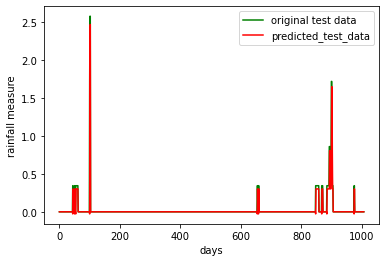

Train Score: 0.06 MSE
Test Score: 0.09 MSE
 Naha


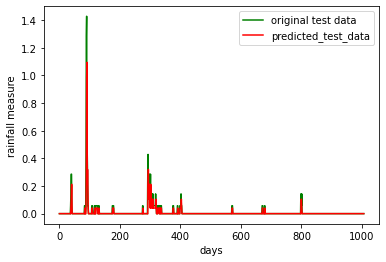

Train Score: 0.02 MSE
Test Score: 0.05 MSE
 Sendai


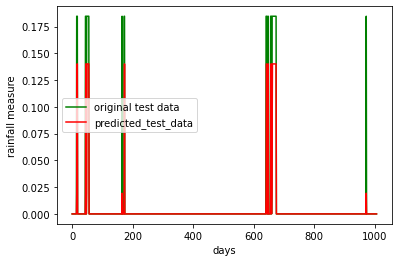

Train Score: 0.02 MSE
Test Score: 0.02 MSE
 Osaka


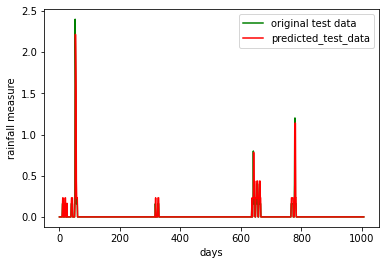

Train Score: 0.03 MSE
Test Score: 0.09 MSE
 Nigata


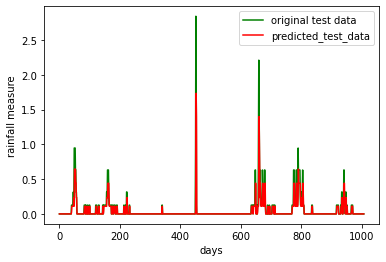

Train Score: 0.04 MSE
Test Score: 0.13 MSE
 Fukuoka


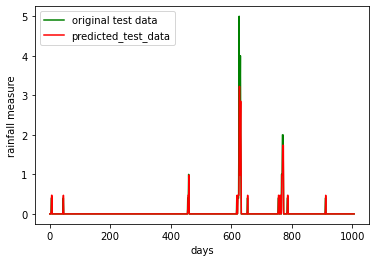

Train Score: 0.08 MSE
Test Score: 0.17 MSE


In [152]:
#loading all the weights
from tensorflow import  keras
from sklearn.metrics import mean_squared_error
for i in range(6):
    close_path = 'C:/Users/91707/OneDrive - LNMIIT/coding/data_Sci/rain_japan'+place_name[i] +'/weights.ckpt'
    model = keras.models.load_model(close_path)
    trainPredict = model.predict(trainX_list[i])
    testPredict = model.predict(testX_list[i])
    #invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    
    trainY = scaler.inverse_transform([trainY_list[i]])
    testPredict = scaler.inverse_transform(testPredict)

    testY = scaler.inverse_transform([testY_list[i]])
    #print(test)
    # calculate root mean squared error
    trainScore = (mean_squared_error(trainY[0], trainPredict[:,0]))
    testPredict = list(testPredict[:,0])
    testY = list(testY[0])
    #testPredict.pop(0)
    #testPredict.append(0)
    for j in range(len(testPredict)):
        if testY[j] ==0:
            testPredict[j]=0
    #testPredict = [0 if x==0.024242464 else x for x in testPredict]
    data_for_csv = {'predicted': testPredict,'ori':testY}
    df = pd.DataFrame(data_for_csv)
    df.to_csv('prediction_csv_of_'+ place_name[i] + '.csv')
    print(place_name[i])
    #plt.plot(trainPredict[:,0],color ='blue')
    #plt.plot(trainY[0])
    plt.xlabel('days')
    plt.ylabel('rainfall measure')
    plt.plot(testY,color='green')
    plt.plot(testPredict,color = 'red')
    plt.legend(['original test data','predicted_test_data'])
    plt.show()
    print('Train Score: %.2f MSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f MSE' % (testScore))

(1,)

In [30]:
def create_dataset_last_val(dataset, look_back=1):
	dataX, dataY = [], []
    #print(len(dataset))
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		#print(dataX)
		#dataY.append(dataset[i + look_back, 0])
	return np.array(dataX)

In [38]:
dataset = np.array([[0.1]])
print(dataset.shape)


(1, 1)


In [43]:
n = int(input())
for i in range(6):
    last_val = testY_list[i][-1]
    #last_val = np.array([[last_val]])
    print(last_val)
    path = 'C:/Users/91707/OneDrive - LNMIIT/coding/data_Sci/rain_japan'+place_name[i] +'/weights.ckpt'
    model = keras.models.load_model(path)
    print('hey')
    for j in range(48*n):
        
        #last_val = np.array([[last_val]])
        #last_val = np.array([[last_val]])
        testx = last_val
        #testx = create_dataset_last_val(last_val)
        #print(testx.shape)
        testx = np.reshape(testx, (testx.shape[0], testx.shape[1], 1))
        lastpred = model.predict(testx)
        #trunc(vec, decs=2)
        last_val = lastpred
        print(last_val)

0.0
hey


IndexError: tuple index out of range